In [284]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


np.random.seed(0)

### 1

დააგენერირეთ შემთხვევითი მონაცემები საცხოვრებლის ფასების პროგნოზირებისთვის. მახასიათებლები „ფართობი&quot;, „ოთახების რაოდენობა“, „საძინებლების რაოდენობა&quot;, „ფასი“. შემთხვევით მონაცემები დააგენერირეთ შემდეგი ლოგიკით „ფართობი“ და „საძინებლების რაოდენობა“ ერთმანეთთან არის დაახოლებით 90% კორელაციაში, ფართობი და ფასები დაახლოებით 84% კორელაციაში. ააგეთ წრფივი რეგრესიული მოდელი ოთახების რაოდენობასა და ფართობის შესაბამისად, გამოთვალეთ 5 სხვადასხვა მონაცემისთვის.

In [102]:
def gen_corr_arrays(corr, low_x, high_x, low_y, high_y, n=1000):
    xx = np.array([low_x, high_x])
    yy = np.array([low_y, high_y])

    means = [xx.mean(), yy.mean()]  
    stds = [xx.std() / 3, yy.std() / 3]
    covs = [
        [stds[0]**2, stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr, stds[1]**2]
    ]

    x = np.random.multivariate_normal(means, covs, n).T
    return x[0], x[1]

In [264]:
N = 1000
rooms = np.random.randint(1, 10, size=N)
area, bedrooms = gen_corr_arrays(.9, low_x=10, high_x=120, low_y=1, high_y=5, n=N)
_, price = gen_corr_arrays(.84, low_x=10, high_x=120, low_y=10000, high_y=200000, n=N)

In [276]:
df = pd.DataFrame({
    "area": area,
    "rooms": rooms,
    "bedrooms": bedrooms.astype(int),
    "price": price.round(2)
})

In [285]:
X = df[["area", "rooms", "bedrooms"]]
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=42)

In [286]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

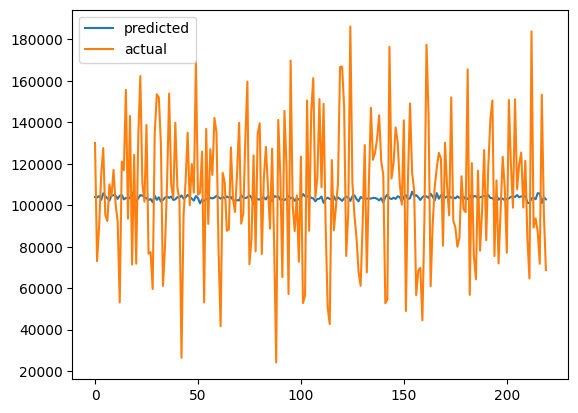

In [307]:
plt.plot(reg.predict(X_test))
plt.plot(y_test.tolist())
plt.legend(["predicted", "actual"])

### 2

დააგენერირეთ შემთხვევითი მონაცემები მანქანის ფასის პროგნოზირებისთვის. მახასიათებლები „ძრავის მოცულობა“, „მაქსიმალური სიჩქარე“, „გამოშვების წელი“, „ფასი“. დააგენერირეთ 500 შემთხვევით მონაცემი შესაბამისი გონივრულად განსაზღვრული დიაპაზონიდან, იპოვეთ მონაცემებს შორის კორელაციის კოეფიციენტი რეგრესიული ანალიზის შესაბამისად.

In [341]:
engine_displacement = np.random.uniform(1, 8, size=500) 
speed = engine_displacement * 45
year = np.random.randint(1999, 2024, size=500)
price = (2 * engine_displacement + 1.5 * speed + .2 * year) * 100

df = pd.DataFrame({
    "engine_displacement": engine_displacement,
    "top_speed": speed,
    "year": year,
    "price": price
})
df.corr()

,engine_displacement,top_speed,year,price
engine_displacement,1.000000,1.000000,-0.105974,0.999942
top_speed,1.000000,1.000000,-0.105974,0.999942
year,-0.105974,-0.105974,1.000000,-0.095287
price,0.999942,0.999942,-0.095287,1.000000


### 3

მოიძიეთ ვალუტის კურსის „დოლარი-ლარი“, „დოლარი-ევრო“, „დოლარი-რუბლი“ ბოლო 3 წლის განმავლობაში ყოველდღიური კურსი, გააკეთეთ მომავალი ერთი კვირის პროგნოზი რეგრესიული ანალიზის საშუალებით.

In [59]:
df = pd.read_csv("./data/usd_exchange_rate_history.csv", index_col=0)

In [60]:
df["EUR.L1"] = df["EUR"].shift(1)
df["GBP.L1"] = df["GBP"].shift(1)
df["GEL.L1"] = df["GEL"].shift(1)

In [61]:
df.dropna(inplace=True)

In [86]:
def build_model(currency: str):
    X = df[[f"{currency}.L1"]]
    y = df[currency]

    cutoff = int(len(X) * .8)
    X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
    X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

    reg = LinearRegression()
    reg.fit(X_train, y_train)

    df_pred_test = pd.DataFrame({
        "y_test": y_test,
        "y_pred": reg.predict(X_test),
    })
    return reg, df_pred_test

0.0 + 1.0 * EUR.L1
0.01 + 1.0 * GEL.L1
0.0 + 1.0 * GBP.L1


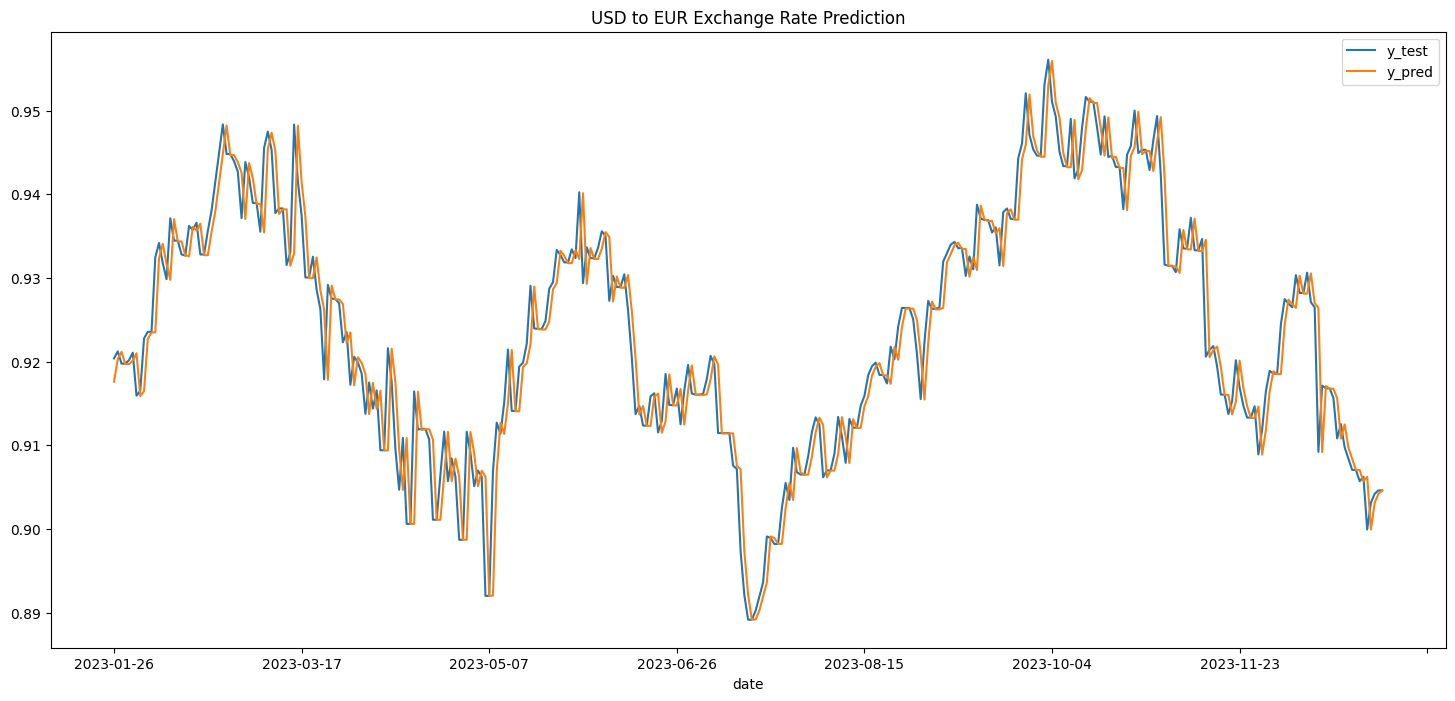

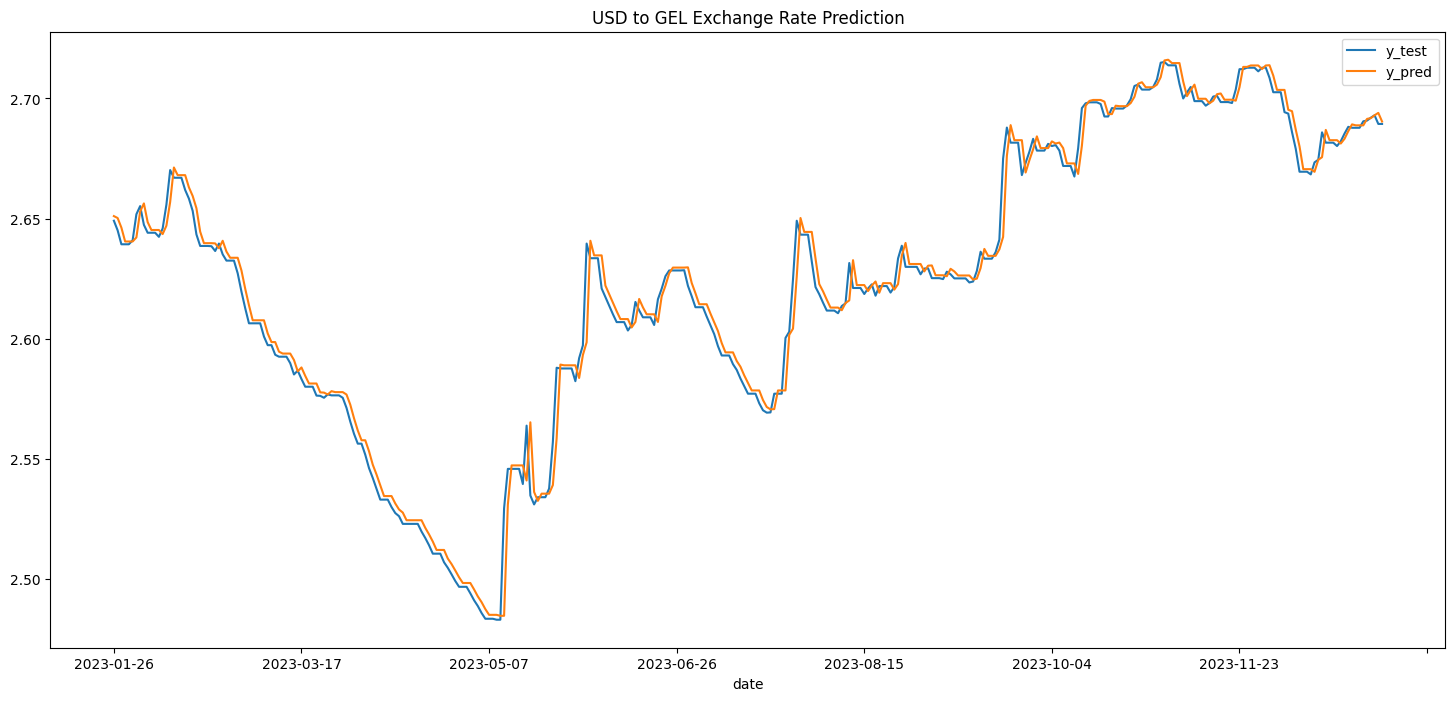

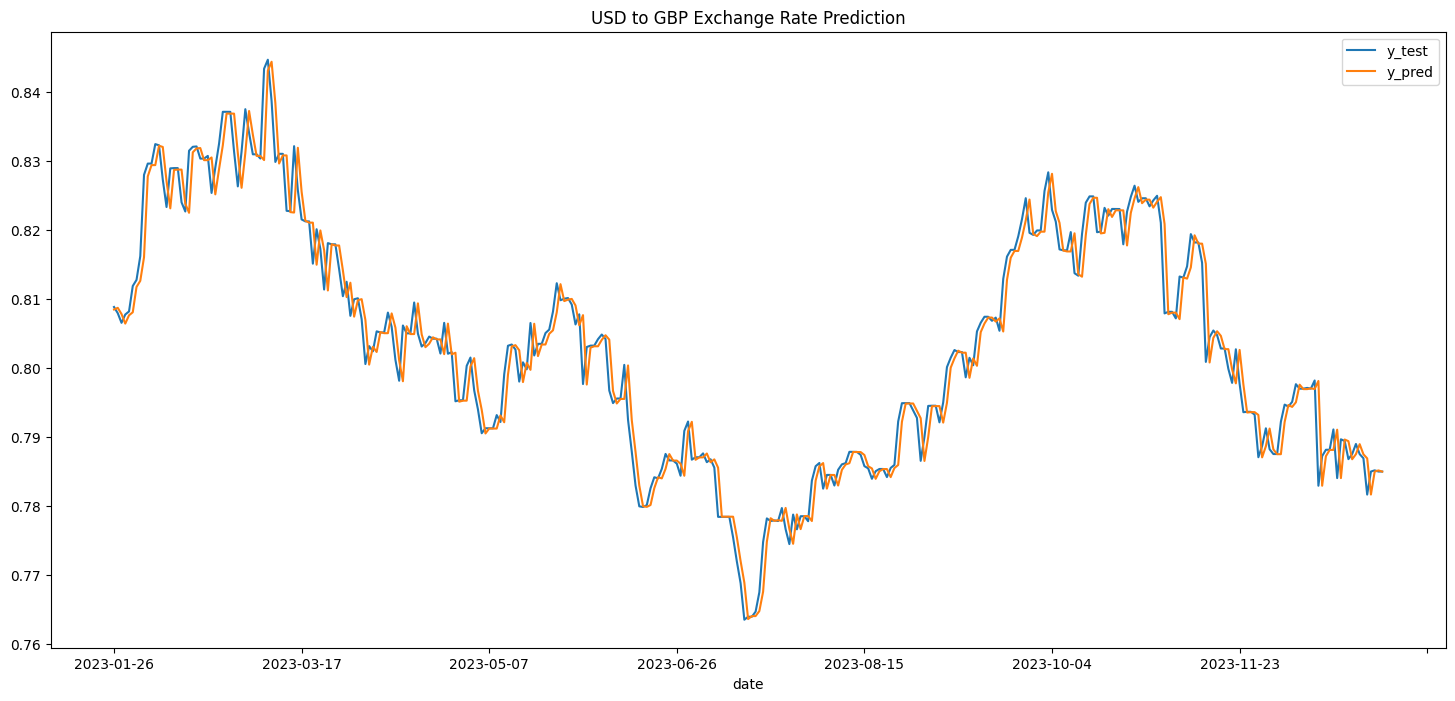

In [96]:
for c in ["EUR", "GEL", "GBP"]:
    model, df_pred_test = build_model(c)
    print(f"{model.intercept_.round(2)} + {model.coef_[0].round(2)} * {c}.L1")
    df_pred_test.plot(figsize=(18, 8), title=f"USD to {c} Exchange Rate Prediction")